# Simulation Experiments

## Load Model

In [83]:
import pysd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import yaml
import numpy as np

current_dir = Path.cwd()
BASE_DIR = current_dir.parent if current_dir.name == 'notebooks' else current_dir
os.chdir(BASE_DIR)

# Load the default parameters
with open(BASE_DIR / 'params.yaml', 'r') as file:
    BASE_PARAMS = yaml.safe_load(file)

model = pysd.load('src/model.py')



## Highest Tax & Emission Trade-off

- Binary search over a tax range to find the maximum sustainable tax. 
- Simulate all taxes up to frontier and compute CO2 reduction vs profitability.

### Max Tax

In [84]:
from src.utils import calculate_max_viable_tax

tax_frontier = calculate_max_viable_tax(model, BASE_PARAMS)

print(tax_frontier)

4921


### CO2 Reduction vs Profitability

In [85]:
return_columns = [
    "cumulative_co2",
    "cumulative_profit",
    "viability_flag"
]

baseline_run = model.run(params=BASE_PARAMS, return_columns=return_columns)

co2_base = baseline_run["cumulative_co2"].iloc[-1]
profit_base = baseline_run["cumulative_profit"].iloc[-1]

# Vector of taxes to simulate. Using 30 points for now.
tax_grid = np.linspace(BASE_PARAMS["carbon_tax_rate"], tax_frontier, 30)

results_list = []

for tax in tax_grid:
    params = BASE_PARAMS.copy()
    params["carbon_tax_rate"] = tax
    sim_results = model.run(
        params=params,
        return_columns=return_columns
    )


    co2 = sim_results["cumulative_co2"].iloc[-1]
    profit = sim_results["cumulative_profit"].iloc[-1]

    viability_flag = sim_results["viability_flag"].iloc[-1]

    co2_reduction_pct = 100 * (1 - co2 / co2_base)
    profit_change_pct = 100 * ((profit - profit_base) / profit_base)

    results_list.append({
        "tax": tax,
        "co2": co2,
        "profit": profit,
        "co2_reduction_pct": co2_reduction_pct,
        "profit_change_pct": profit_change_pct,
        "viable": viability_flag
    })

results_df = pd.DataFrame(results_list)

# assert (results_df["viable"] == 1).all(), "Some simulations are not viable"



### Visualisation

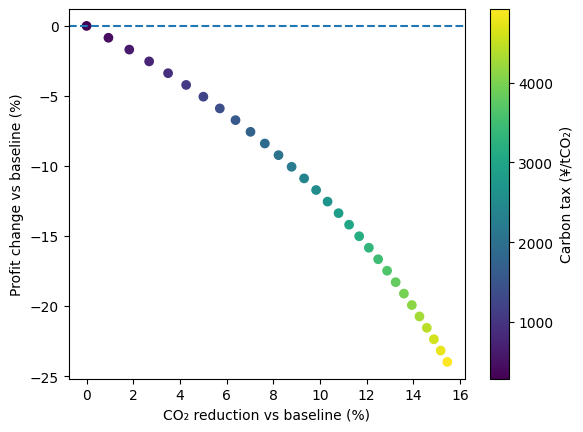

In [86]:
fig, ax = plt.subplots()

sc = ax.scatter(
    results_df["co2_reduction_pct"],
    results_df["profit_change_pct"],
    c=results_df["tax"],  # color by tax level
)
ax.axhline(0, linestyle="--")  # zero profit-change line
ax.set_xlabel("CO₂ reduction vs baseline (%)")
ax.set_ylabel("Profit change vs baseline (%)")
plt.colorbar(sc, label="Carbon tax (¥/tCO₂)")

In [87]:
x = results_df["co2_reduction_pct"]
y = results_df["profit_change_pct"]

coef_linear = np.polyfit(x, y, 1)
y_linear = np.polyval(coef_linear, x)

ss_res = np.sum((y - y_linear) ** 2)
ss_tot = np.sum((y - np.mean(y)) ** 2)
r_squared = 1 - ss_res / ss_tot

print(f"R-squared: {r_squared}")

coef_quad = np.polyfit(x, y, 2)
y_quad = np.polyval(coef_quad, x)

ss_res_q = np.sum((y - y_quad)**2)
r2_quad = 1 - ss_res_q/ss_tot

print("Quadratic fit R^2:", r2_quad)


# Sort by CO2 reduction
df_sorted = results_df.sort_values("co2_reduction_pct")
x = df_sorted["co2_reduction_pct"].values
y = df_sorted["profit_change_pct"].values

# second finite difference (approx curvature sign)
second_diff = np.diff(y, 2)  # length N-2
print("Mean second difference:", second_diff.mean())
print("Max abs second difference:", np.abs(second_diff).max())

R-squared: 0.9744607757703123
Quadratic fit R^2: 0.9991257151881273
Mean second difference: 0.0012757993592133754
Max abs second difference: 0.0013675493791700521


## Sensitivity & Leverage Points

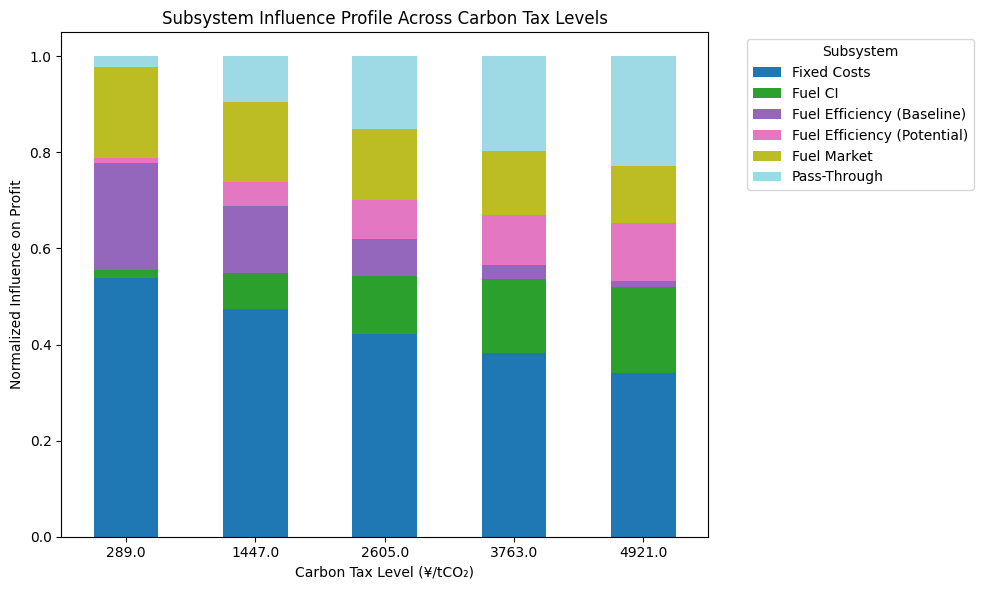

In [88]:
from src.utils import one_at_a_time_sensitivity_analysis

subsystem_map = {
    "carbon_content_of_fuel": "Fuel CI",
    "baseline_fuel_efficiency": "Fuel Efficiency (Baseline)",
    "max_efficiency": "Fuel Efficiency (Potential)",
    "nonfuel_cost_per_km": "Fixed Costs",
    "pretax_fuel_price": "Fuel Market",
    "desired_passthrough_share": "Pass-Through",
}

# Tax levels: we choose levels within the range of the tax frontier
tax_levels = np.linspace(BASE_PARAMS["carbon_tax_rate"], tax_frontier, 5)

key_params_policy = {
    # Fuel supply / CI
    "carbon_content_of_fuel": np.linspace(BASE_PARAMS["carbon_content_of_fuel"] * 0.7,
                               BASE_PARAMS["carbon_content_of_fuel"] * 1.3, 5),

    # Fleet efficiency: starting point + potential
    "baseline_fuel_efficiency": np.linspace(BASE_PARAMS["baseline_fuel_efficiency"] * 0.8,
                                            BASE_PARAMS["baseline_fuel_efficiency"] * 1.2, 5),
    "max_efficiency": np.linspace(BASE_PARAMS["max_efficiency"] * 0.9,
                                  BASE_PARAMS["max_efficiency"] * 1.1, 5),

    # Cost structure
    "nonfuel_cost_per_km": np.linspace(BASE_PARAMS["nonfuel_cost_per_km"] * 0.8,
                                       BASE_PARAMS["nonfuel_cost_per_km"] * 1.2, 5),

    # Fuel market
    "pretax_fuel_price": np.linspace(BASE_PARAMS["pretax_fuel_price"] * 0.8,
                                     BASE_PARAMS["pretax_fuel_price"] * 1.2, 5),

    # Market / pass-through
    "desired_passthrough_share": np.linspace(BASE_PARAMS["desired_passthrough_share"] * 0.6,
                                             BASE_PARAMS["desired_passthrough_share"] * 1.4, 5),
}


results = one_at_a_time_sensitivity_analysis(model, BASE_PARAMS, key_params_policy, tax_levels)

# Calculate normalized influence (range of profit_change_pct) for each parameter at each tax level
influence_data = []
for tax in tax_levels:
    tax_data = results[results['tax'] == tax]
    for param_name in key_params_policy.keys():
        param_data = tax_data[tax_data['param_name'] == param_name]['profit_change_pct']
        if len(param_data) > 0:
            influence = abs(param_data.max() - param_data.min())  # Range as influence measure
            influence_data.append({
                'tax': tax,
                'param_name': subsystem_map.get(param_name, param_name),
                'influence': influence
            })

# Create DataFrame and pivot for plotting
influence_df = pd.DataFrame(influence_data)
plot_df = influence_df.pivot(index='tax', columns='param_name', values='influence')

# Normalize by total influence at each tax level (so bars sum to 1)
plot_df_normalized = plot_df.div(plot_df.sum(axis=1), axis=0)

# Create the plot
plt.figure(figsize=(10, 6))
plot_df_normalized.plot(
    kind="bar",
    stacked=True,
    colormap="tab20",
    ax=plt.gca()
)

plt.ylabel("Normalized Influence on Profit")
plt.xlabel("Carbon Tax Level (¥/tCO₂)")
plt.title("Subsystem Influence Profile Across Carbon Tax Levels")
plt.legend(title="Subsystem", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



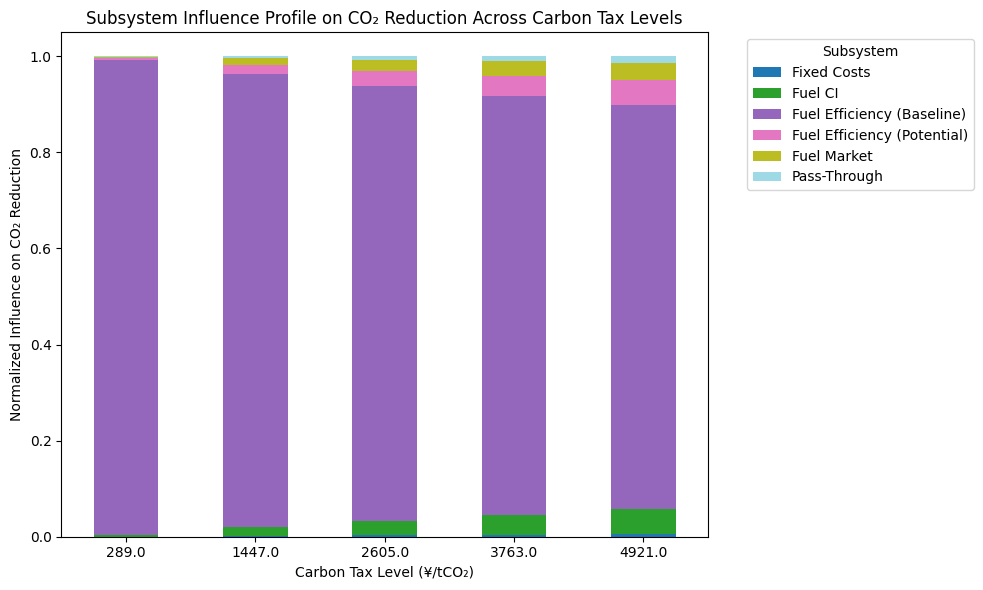

In [89]:
# Calculate normalized influence (range of co2_reduction_pct) for each parameter at each tax level
influence_data_co2 = []
for tax in tax_levels:
    tax_data = results[results['tax'] == tax]
    for param_name in key_params_policy.keys():
        param_data = tax_data[tax_data['param_name'] == param_name]['co2_reduction_pct']
        if len(param_data) > 0:
            influence = abs(param_data.max() - param_data.min())  # Range as influence measure
            influence_data_co2.append({
                'tax': tax,
                'param_name': subsystem_map.get(param_name, param_name),
                'influence': influence
            })

# Create DataFrame and pivot for plotting
influence_df_co2 = pd.DataFrame(influence_data_co2)
plot_df_co2 = influence_df_co2.pivot(index='tax', columns='param_name', values='influence')

# Normalize by total influence at each tax level (so bars sum to 1)
plot_df_co2_normalized = plot_df_co2.div(plot_df_co2.sum(axis=1), axis=0)

# Create the plot
plt.figure(figsize=(10, 6))
plot_df_co2_normalized.plot(
    kind="bar",
    stacked=True,
    colormap="tab20",
    ax=plt.gca()
)

plt.ylabel("Normalized Influence on CO₂ Reduction")
plt.xlabel("Carbon Tax Level (¥/tCO₂)")
plt.title("Subsystem Influence Profile on CO₂ Reduction Across Carbon Tax Levels")
plt.legend(title="Subsystem", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
